## Import Libraries 

In [1]:
import warnings
import sys
sys.path.insert(0, '../../src')
warnings.filterwarnings('ignore')

In [2]:
import ABC_train_test2
import bostonDataset
import network
import dataset
import sanityChecks
import performanceMetrics
import torch 
from torch.utils.data import random_split 
import scrapbook as sb
from statistics import mean 
import catboost as ctb 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np

## Parameters 

In [3]:
variance = 1

## Dataset - Boston Housing 

In [4]:
#Parameters 
n_features = 13
n_samples= 506
n_target = 1 

In [5]:
X,Y = bostonDataset.boston_data()

         X1        X2        X3        X4        X5        X6        X7  \
0 -0.419782  0.284830 -1.287909 -0.272599 -0.144217  0.413672 -0.120013   
1 -0.417339 -0.487722 -0.593381 -0.272599 -0.740262  0.194274  0.367166   
2 -0.417342 -0.487722 -0.593381 -0.272599 -0.740262  1.282714 -0.265812   
3 -0.416750 -0.487722 -1.306878 -0.272599 -0.835284  1.016303 -0.809889   
4 -0.412482 -0.487722 -1.306878 -0.272599 -0.835284  1.228577 -0.511180   

         X8        X9       X10       X11       X12       X13         Y  
0  0.140214 -0.982843 -0.666608 -1.459000  0.441052 -1.075562  0.159686  
1  0.557160 -0.867883 -0.987329 -0.303094  0.441052 -0.492439 -0.101524  
2  0.557160 -0.867883 -0.987329 -0.303094  0.396427 -1.208727  1.324247  
3  1.077737 -0.752922 -1.106115  0.113032  0.416163 -1.361517  1.182758  
4  1.077737 -0.752922 -1.106115  0.113032  0.441052 -1.026501  1.487503  


In [6]:
#Train test split for dataset 
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size = 0.2)
train_data = dataset.CustomDataset(X_train,Y_train)
test_data = dataset.CustomDataset(X_test,Y_test)


## Training Parameters 



In [7]:
batch_size = 64
n_epochs = 5000
#Select the device 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ABC Pre-generator Model 

1. The catboost model is used as a pre-generator model for the ABC-GAN. 
2. The model is first trained on the train dataset 
3. It generats X,Y pairs and we add some Gaussian noise with mean 0 and variance V (1,0.01,0.1) to it which is then feed as input to the generator.


In [8]:
#Train the Model 
prior_model = ctb.CatBoostRegressor()
prior_model.fit(X_train,Y_train)

Learning rate set to 0.033215
0:	learn: 0.9910821	total: 57.1ms	remaining: 57.1s
1:	learn: 0.9710973	total: 58.2ms	remaining: 29s
2:	learn: 0.9502628	total: 59.1ms	remaining: 19.6s
3:	learn: 0.9324188	total: 60ms	remaining: 14.9s
4:	learn: 0.9140255	total: 60.9ms	remaining: 12.1s
5:	learn: 0.8954571	total: 62ms	remaining: 10.3s
6:	learn: 0.8785417	total: 63.1ms	remaining: 8.95s
7:	learn: 0.8616623	total: 64.1ms	remaining: 7.95s
8:	learn: 0.8456116	total: 65.1ms	remaining: 7.17s
9:	learn: 0.8282854	total: 66ms	remaining: 6.53s
10:	learn: 0.8131460	total: 67ms	remaining: 6.03s
11:	learn: 0.7972996	total: 68ms	remaining: 5.6s
12:	learn: 0.7824224	total: 68.9ms	remaining: 5.23s
13:	learn: 0.7680121	total: 69.8ms	remaining: 4.92s
14:	learn: 0.7550076	total: 70.7ms	remaining: 4.64s
15:	learn: 0.7409291	total: 71.6ms	remaining: 4.4s
16:	learn: 0.7292639	total: 72.6ms	remaining: 4.2s
17:	learn: 0.7161906	total: 73.5ms	remaining: 4.01s
18:	learn: 0.7031735	total: 74.3ms	remaining: 3.83s
19:	lea

In [9]:
y_pred = prior_model.predict(X_test)
y_abc = y_pred + np.random.normal(0,variance, y_pred.shape)
mse = mean_squared_error(y_pred,Y_test)
sb.glue("Prior Model MSE",mse)
mse = mean_squared_error(y_abc,Y_test)
sb.glue("ABC Pre-generator MSE",mse)

# ABC GAN Model

### Training the network
**Training ABC-GAN for n_epochs number of epochs** 

In [10]:
gen = network.Generator(n_features+1).to(device)
disc = network.Discriminator(n_features+1).to(device)

criterion = torch.nn.BCELoss()
gen_opt = torch.optim.Adam(gen.parameters(), lr=0.001, betas=(0.5, 0.999))
disc_opt = torch.optim.Adam(disc.parameters(), lr=0.01, betas=(0.5, 0.999))

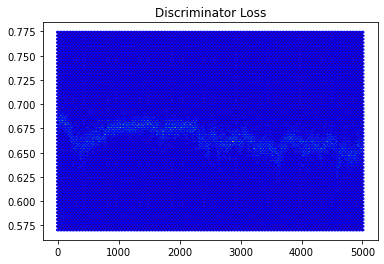

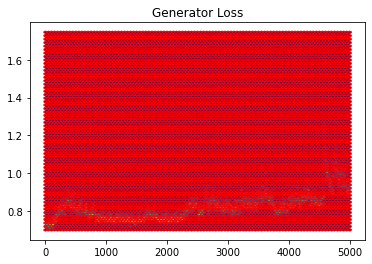

In [11]:
#Training the ABC_GAN 
ABC_train_test2.training_GAN(disc,gen,disc_opt,gen_opt,train_data,batch_size,n_epochs,criterion,prior_model,variance,device)

In [ ]:
ABC_GAN1_metrics=ABC_train_test2.test_generator(gen,test_data,prior_model,variance,"1",device)
sb.glue("ABC_GAN_1 Metrics",ABC_GAN1_metrics)

#### Sanity Checks 

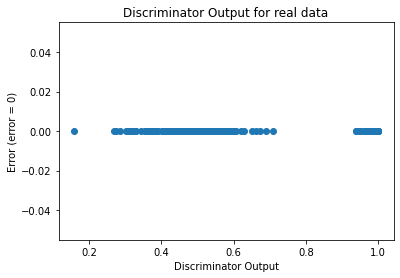

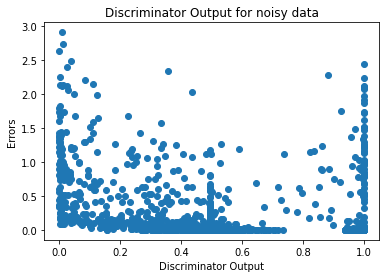

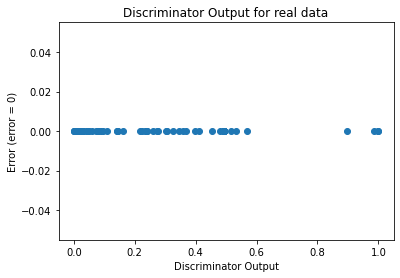

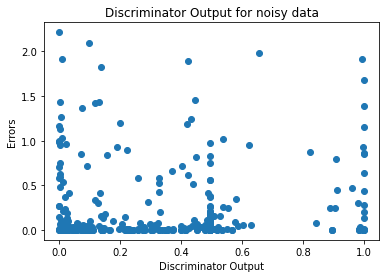

In [13]:
sanityChecks.discProbVsError(train_data,disc,device)
sanityChecks.discProbVsError(test_data,disc,device)

# ABC - GAN Model with skip connection

In [14]:
#Generator
gen3 = network.GeneratorWithSkipConnection(n_features+1).to(device)
constraints=network.weightConstraint()
#Discriminator 
disc3 = network.Discriminator(n_features+1).to(device)

criterion = torch.nn.BCELoss()
gen_opt = torch.optim.Adam(gen3.parameters(), lr=0.01, betas=(0.5, 0.999))
disc_opt = torch.optim.Adam(disc3.parameters(), lr=0.01, betas=(0.5, 0.999))


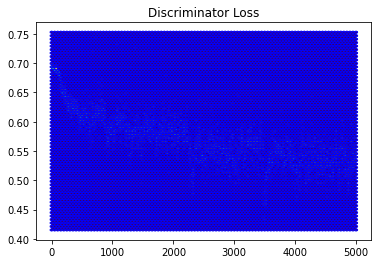

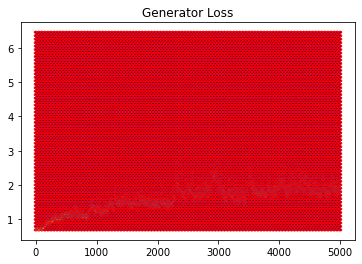

In [15]:
ABC_train_test2.training_GAN_skip_connection(disc3,gen3,disc_opt,gen_opt,train_data,batch_size,n_epochs,criterion,prior_model,variance,device)


In [16]:
ABC_GAN3_metrics=ABC_train_test2.test_generator(gen3,test_data,prior_model,variance,"3",device)
sb.glue("ABC_GAN_3 Metrics",ABC_GAN3_metrics)

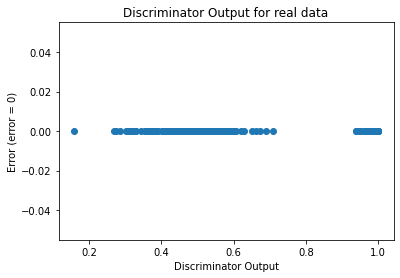

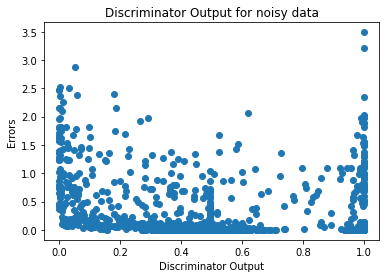

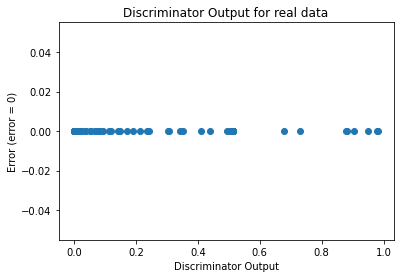

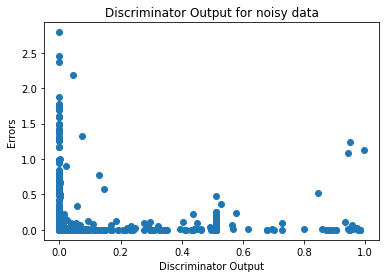

In [17]:
sanityChecks.discProbVsError(train_data,disc,device)
sanityChecks.discProbVsError(test_data,disc3,device)

## Skip Connection Model Analysis - ABC-GAN 

### Weight Analysis 

Study the weights of the skip connection layer

Equation of the skip connection is 

$output = y_{gan} * w + y_{abc} * (1-w)$

In [19]:
print("Weight of the node at skip connection")
for name,param in gen3.named_parameters():
    if(name == "skipNode.weight"):
        print(param)
        sb.glue("Skip Connection Weight",param.item())

Weight of the node at skip connection
Parameter containing:
tensor([[0.9947]], requires_grad=True)
